In [3]:
%matplotlib inline
import numpy as np
from scipy import constants as con
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
from math import e
from matplotlib.table import Table
from scipy.optimize import curve_fit
from collections import Counter

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Global font size settings
plt.rcParams['axes.titlesize'] = 18      # Title font size
plt.rcParams['axes.labelsize'] = 14      # X and Y axis labels
plt.rcParams['xtick.labelsize'] = 14     # X tick labels
plt.rcParams['ytick.labelsize'] = 14     # Y tick labels
plt.rcParams['legend.fontsize'] = 14     # Legend text
plt.rcParams['figure.titlesize'] = 18    # Figure title (if using `fig.suptitle`)

In [4]:
import os
os.path.isfile('C2Data/1')

True

# Laird

In [5]:
# Frequency values (Hz)
freq = np.array([0.1e9, 1e9, 3e9, 6e9, 9e9, 12e9, 15e9, 18e9])
omega = 2 * np.pi * freq

# Material properties for MF-124
epsilon_real = np.array([21.6, 20, 19.1, 18.9, 18.9, 18.9, 18.9, 18.9])  # K'
epsilon_imag = np.array([0.3, 1.3, 0.7, 0.5, 0.4, 0.4, 0.4, 0.4])        # K''
loss_tangent_d = np.array([0, 0.1, 0, 0, 0, 0, 0, 0])                    # tanδ_d
mu_real = np.array([5.6, 5.4, 4, 2.5, 1.8, 1.5, 1.3, 1.2])               # M'
mu_imag = np.array([0.1, 1, 2.2, 2.2, 1.7, 1.4, 1.2, 1])                 # M''
loss_tangent_m = np.array([0, 0.2, 0.6, 0.9, 0.9, 0.9, 0.9, 0.8])        # tanδ_m

A = (2*np.pi*freq)/(con.c)
B = ((epsilon_real * mu_real) / 2)
C = np.sqrt((1 + (loss_tangent_d)**2) * (1 + (loss_tangent_m)**2))
D = (1 - loss_tangent_d * loss_tangent_m)

dBcm = (A * np.sqrt(B * (C - D)))*8.686 / 100

#print('Laird MF-124')
#for i, value in enumerate(dBcm):
#    print(f"Frequency {freq[i]/1e9} GHz: dBcm = {value:.4f} dB/cm")

# Pozar

In [6]:
# Constants
mu_0 = con.mu_0            # Permeability of free space (H/m)
epsilon_0 = con.epsilon_0  # Permittivity of free space (F/m)
sigma_Cu = 5.813e7         # Conductivity of copper (S/m)

# Given discrete frequency values (Hz)
freq = np.array([0.1e9, 1e9, 3e9, 6e9, 9e9, 12e9, 15e9, 18e9])  # Hz
omega = 2 * np.pi * freq  # Angular frequency (rad/s)

# Corresponding material properties
# !!! FOR MF-124 !!!
epsilon_real = np.array([21.6, 20, 19.1, 18.9, 18.9, 18.9, 18.9, 18.9]) # K'      Real part of permittivity (dielectric constant)
loss_tangent_d = np.array([0, 0.1, 0, 0, 0, 0, 0, 0])                   # tanδ_d  Dielectric loss tangent
epsilon_imag = np.array([0.3, 1.3, 0.7, 0.5, 0.4, 0.4, 0.4, 0.4])       # K''     Imaginary part of permittivity (loss)
epsilon_complex = epsilon_real * (1 - 1j * loss_tangent_d)
epsilon = epsilon_0 * epsilon_complex
    
mu_real = np.array([5.6, 5.4, 4, 2.5, 1.8, 1.5, 1.3, 1.2])              # M'      Real part of magnetic permeability 
loss_tangent_m = np.array([0, 0.2, 0.6, 0.9, 0.9, 0.9, 0.9, 0.8])       # tanδ_m  Magnetic loss tangent 
mu_imag = np.array([0.1, 1, 2.2, 2.2, 1.7, 1.4, 1.2, 1])                # M''     Imaginary part of magnetic permeability (loss)
mu_complex = mu_real * (1 - 1j * loss_tangent_m) 
mu = mu_0 * mu_complex                                                  # Absolute permeability

# Geometry
a_2 = 0.92e-3  # Inner radius of Eccosorb MF core (also the outer radius of the pin!) (m)
b_2 = 4.75e-3  # Outer radius of Eccosorb MF core (m)
z = 9.74e-3     # Length of Eccosorb (m)


# L, C, G calculations
L = (mu / (2 * np.pi)) * np.log(b_2 / a_2)          # Inductance of conductor (pin) (H/m)
C = (2 * np.pi * epsilon.real) / np.log(b_2 / a_2)  # Capacitance of dielectric (Ecco) (F/m)
G = (omega * (epsilon).imag) / np.log(b_2 / a_2)    # Conductance of dielectric (Ecco) (S/m)

# Surface resistance & R calculation
delta_s = np.sqrt(2 / (omega * mu_0 * sigma_Cu))
R_s = 1 / (sigma_Cu * delta_s)                 # Surface resistance of conductor (pin) (Ω)
R = (R_s / (2 * np.pi)) * (1 / a_2 + 1 / b_2)  # Resistance of conductor (pin) (Ω/m)

# Complex propagation constant for lossy transmission line
gamma_lossy = np.sqrt((R + 1j * omega * L) * (G + 1j * omega * C))

# Attenuation constant
alpha = np.real(gamma_lossy)  # Attenuation constant (Np/m)

# Voltage attenuation
V_0 = 1  # Initial amplitude (applied voltage)
V_in = V_0 * np.exp(-alpha * 0)  # V_2
V_out = V_0 * np.exp(-alpha * z) # V_1

# Convert attenuation to dB
attenuation_dB = -(20 * np.log10(V_out)) # S_21 = (V_2 / V_1) = V_2 (because V_1=1) = V_out
attenuation_dB_cm = attenuation_dB / (z * 100)

#print('Pozar MF-124')
#for i, value in enumerate(attenuation_dB_cm):
#    print(f"Frequency {freq[i]/1e9} GHz: dBcm = {value:.4f} dB/cm")

File with most min values: C2Data/4
File with most max values: C2Data/10
File with most median values: C2Data/13


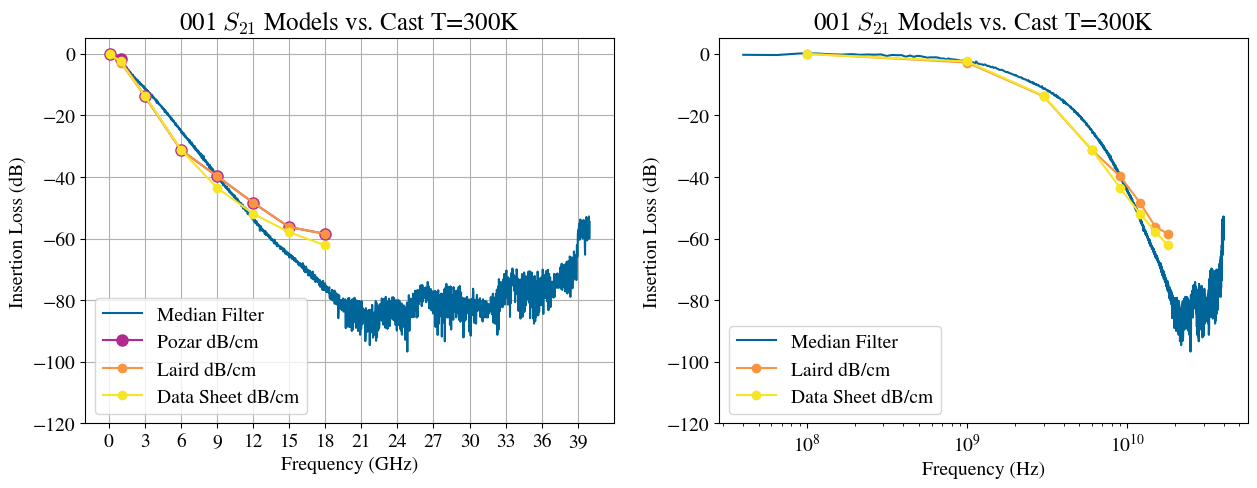

In [14]:
# Load data
C_files = [f'C2Data/{i}' for i in range(1, 20)]
C_data = [np.loadtxt(f, delimiter='\t') for f in C_files]
#B = np.loadtxt('CData/Background', delimiter='\t')
#xB = (B[:,0])/1e9
#yB = (B[:,1])

# Extract frequency (assuming all files have the same x-axis)
x_vals = C_data[0][:, 0]/1e9

# Stack all y-values for statistical calculations
y_vals = np.array([C[:, 1] for C in C_data])  # Shape: (19, N)

# Find indices of min, max, and median curves
min_idx = np.argmin(y_vals, axis=0)  # Indices of min values at each frequency
max_idx = np.argmax(y_vals, axis=0)  # Indices of max values at each frequency
median_idx = np.argsort(y_vals, axis=0)[len(C_data) // 2]  # Indices of median values

# Convert dataset indices to filenames
min_files = [C_files[i] for i in min_idx]
max_files = [C_files[i] for i in max_idx]
median_files = [C_files[i] for i in median_idx]

# Find the most frequently occurring file in each category
most_common_min_file = Counter(min_files).most_common(1)[0][0]
most_common_max_file = Counter(max_files).most_common(1)[0][0]
most_common_median_file = Counter(median_files).most_common(1)[0][0]

# Print the files
print("File with most min values:", most_common_min_file)
print("File with most max values:", most_common_max_file)
print("File with most median values:", most_common_median_file)

# Get the dataset that corresponds to min, max, and median
y_min_curve = y_vals[min_idx, np.arange(y_vals.shape[1])]
y_max_curve = y_vals[max_idx, np.arange(y_vals.shape[1])]
y_median_curve = y_vals[median_idx, np.arange(y_vals.shape[1])]

# Linear 

# Target frequencies (Hz)
target_freq = np.array([0.1e9, 1e9, 3e9, 6e9, 9e9, 12e9, 15e9, 18e9])

# Data sheet dB/cm
dB_per_cm = np.array([0.1, 2.5, 13.6, 31.1, 43.5, 51.9, 57.9, 62.2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Set x-ticks from 0 to 40 GHz in steps of 5 GHz
xticks_full = np.arange(0, 41, 3)

# Linear scale
ax1.plot(x_vals, y_median_curve, label='Median Filter', color=plt.cm.ocean(0.6))
#ax1.fill_between(x_vals, y_min_curve/z, y_max_curve, alpha=0.2, label='Variation (19 Filters)')#, color=plt.cm.plasma(0.1))
ax1.plot(freq/1e9, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.plasma(0.4))
ax1.plot(target_freq/1e9, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color=plt.cm.plasma(0.75))
ax1.plot(target_freq/1e9, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.plasma(0.95))
ax1.ticklabel_format(useOffset=True)
ax1.legend(loc='lower left')
ax1.set_title("001 $S_{21}$ Models vs. Cast T=300K")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Insertion Loss (dB)")
ax1.set_ylim(-120, 5)
ax1.set_xticks(xticks_full)
ax1.grid(which='both');

# log scale
ax2.plot(x_vals*1e9, y_median_curve, label='Median Filter', color=plt.cm.ocean(0.6))
#ax2.fill_between(x_vals*1e9, y_min_curve, y_max_curve, alpha=0.2, label='Variation (19 Filters)')#, color=plt.cm.plasma(0.1))
#ax2.plot(freq, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.plasma(0.4))
ax2.plot(target_freq, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color=plt.cm.plasma(0.75))
ax2.plot(target_freq, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.plasma(0.95))
ax2.ticklabel_format(useOffset=False)
ax2.legend(loc='lower left')
ax2.set_title("001 $S_{21}$ Models vs. Cast T=300K")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_xscale('log')
ax2.set_ylabel("Insertion Loss (dB)")
ax2.set_ylim(-120, 5);


plt.savefig("001_Models_vs_Cast.jpg", facecolor="w")

File with most min values: MData/15
File with most max values: MData/2
File with most median values: MData/4


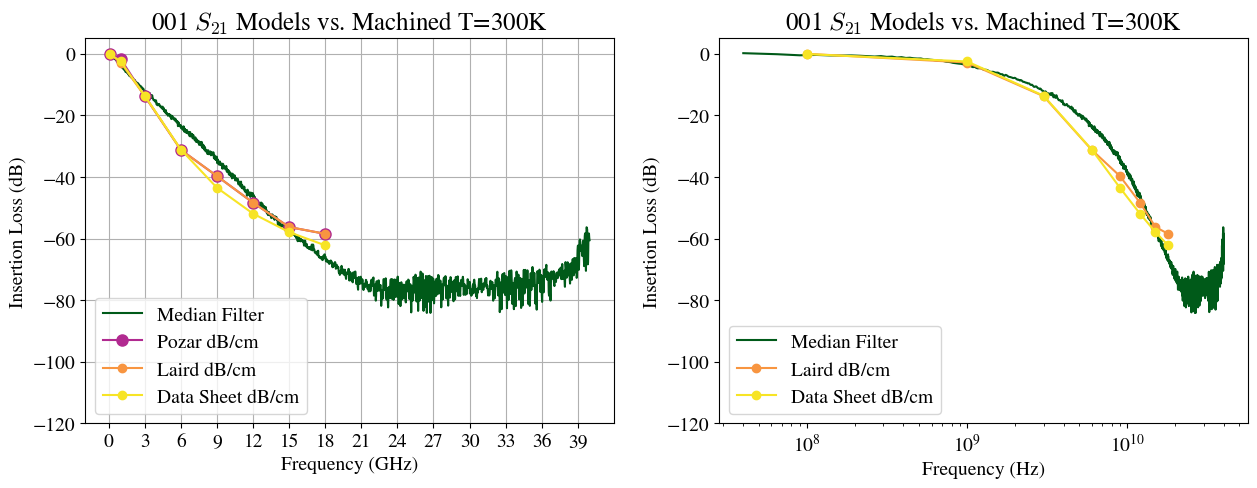

In [16]:
# Load data
M_files = [f'MData/{i}' for i in range(1, 20)]
M_data = [np.loadtxt(f, delimiter='\t') for f in M_files]
#B = np.loadtxt('CData/Background', delimiter='\t')
#xB = (B[:,0])/1e9
#yB = (B[:,1])

# Extract frequency (assuming all files have the same x-axis)
x_vals = M_data[0][:, 0]/1e9

# Stack all y-values for statistical calculations
y_vals = np.array([M[:, 1] for M in M_data])  # Shape: (19, N)

# Find indices of min, max, and median curves
min_idx = np.argmin(y_vals, axis=0)  # Indices of min values at each frequency
max_idx = np.argmax(y_vals, axis=0)  # Indices of max values at each frequency
median_idx = np.argsort(y_vals, axis=0)[len(M_data) // 2]  # Indices of median values

# Convert dataset indices to filenames
min_files = [M_files[i] for i in min_idx]
max_files = [M_files[i] for i in max_idx]
median_files = [M_files[i] for i in median_idx]

# Find the most frequently occurring file in each category
most_common_min_file = Counter(min_files).most_common(1)[0][0]
most_common_max_file = Counter(max_files).most_common(1)[0][0]
most_common_median_file = Counter(median_files).most_common(1)[0][0]

# Print the files
print("File with most min values:", most_common_min_file)
print("File with most max values:", most_common_max_file)
print("File with most median values:", most_common_median_file)

# Get the dataset that corresponds to min, max, and median
y_min_curve = y_vals[min_idx, np.arange(y_vals.shape[1])]
y_max_curve = y_vals[max_idx, np.arange(y_vals.shape[1])]
y_median_curve = y_vals[median_idx, np.arange(y_vals.shape[1])]

# Linear 

# Target frequencies (Hz)
target_freq = np.array([0.1e9, 1e9, 3e9, 6e9, 9e9, 12e9, 15e9, 18e9])

# Data sheet dB/cm
dB_per_cm = np.array([0.1, 2.5, 13.6, 31.1, 43.5, 51.9, 57.9, 62.2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Set x-ticks from 0 to 40 GHz in steps of 5 GHz
xticks_full = np.arange(0, 41, 3)

# Linear scale
ax1.plot(x_vals, y_median_curve, label='Median Filter', color=plt.cm.ocean(0.1))
#ax1.fill_between(x_vals, y_min_curve/z, y_max_curve, alpha=0.2, label='Variation (19 Filters)')#, color=plt.cm.plasma(0.1))
ax1.plot(freq/1e9, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.plasma(0.4))
ax1.plot(target_freq/1e9, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color=plt.cm.plasma(0.75))
ax1.plot(target_freq/1e9, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.plasma(0.95))
ax1.ticklabel_format(useOffset=True)
ax1.legend(loc='lower left')
ax1.set_title("001 $S_{21}$ Models vs. Machined T=300K")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Insertion Loss (dB)")
ax1.set_ylim(-120, 5)
ax1.set_xticks(xticks_full)
ax1.grid(which='both');

# log scale
ax2.plot(x_vals*1e9, y_median_curve, label='Median Filter', color=plt.cm.ocean(0.1))
#ax2.fill_between(x_vals*1e9, y_min_curve, y_max_curve, alpha=0.2, label='Variation (19 Filters)')#, color=plt.cm.plasma(0.1))
#ax2.plot(freq, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.plasma(0.4))
ax2.plot(target_freq, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color=plt.cm.plasma(0.75))
ax2.plot(target_freq, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.plasma(0.95))
ax2.ticklabel_format(useOffset=False)
ax2.legend(loc='lower left')
ax2.set_title("001 $S_{21}$ Models vs. Machined T=300K")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_xscale('log')
ax2.set_ylabel("Insertion Loss (dB)")
ax2.set_ylim(-120, 5);


plt.savefig("001_Models_vs_Mach.jpg", facecolor="w")



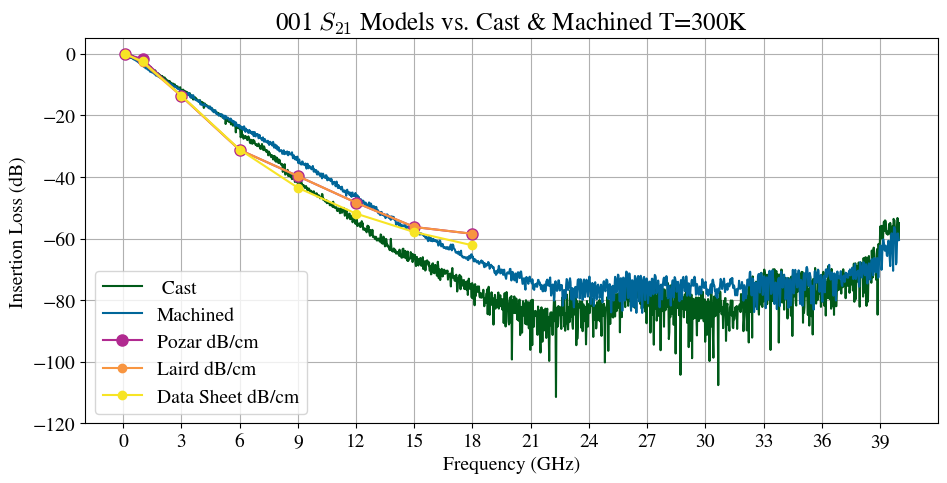

In [21]:
# Load data
C_files = [f'C2Data/{i}' for i in range(1, 20)]
C_data = [np.loadtxt(f, delimiter='\t') for f in C_files]
#B = np.loadtxt('CData/Background', delimiter='\t')
#xB = (B[:,0])/1e9
#yB = (B[:,1])

# Extract frequency (assuming all files have the same x-axis)
Cx_vals = C_data[0][:, 0]/1e9

# Stack all y-values for statistical calculations
Cy_vals = np.array([C[:, 1] for C in C_data])  # Shape: (19, N)

# Find indices of min, max, and median curves
Cmin_idx = np.argmin(Cy_vals, axis=0)  # Indices of min values at each frequency
Cmax_idx = np.argmax(Cy_vals, axis=0)  # Indices of max values at each frequency
Cmedian_idx = np.argsort(Cy_vals, axis=0)[len(C_data) // 2]  # Indices of median values

# Convert dataset indices to filenames
Cmin_files = [C_files[i] for i in Cmin_idx]
Cmax_files = [C_files[i] for i in Cmax_idx]
Cmedian_files = [C_files[i] for i in Cmedian_idx]

# Find the most frequently occurring file in each category
Cmost_common_min_file = Counter(Cmin_files).most_common(1)[0][0]
Cmost_common_max_file = Counter(Cmax_files).most_common(1)[0][0]
Cmost_common_median_file = Counter(Cmedian_files).most_common(1)[0][0]

# Get the dataset that corresponds to min, max, and median
Cy_min_curve = Cy_vals[min_idx, np.arange(Cy_vals.shape[1])]
Cy_max_curve = Cy_vals[max_idx, np.arange(Cy_vals.shape[1])]
Cy_median_curve = Cy_vals[median_idx, np.arange(Cy_vals.shape[1])]

# Linear 

# Target frequencies (Hz)
target_freq = np.array([0.1e9, 1e9, 3e9, 6e9, 9e9, 12e9, 15e9, 18e9])

# Data sheet dB/cm
dB_per_cm = np.array([0.1, 2.5, 13.6, 31.1, 43.5, 51.9, 57.9, 62.2])

# Load data
M_files = [f'MData/{i}' for i in range(1, 20)]
M_data = [np.loadtxt(f, delimiter='\t') for f in M_files]
#B = np.loadtxt('CData/Background', delimiter='\t')
#xB = (B[:,0])/1e9
#yB = (B[:,1])

# Extract frequency (assuming all files have the same x-axis)
Mx_vals = M_data[0][:, 0]/1e9

# Stack all y-values for statistical calculations
My_vals = np.array([M[:, 1] for M in M_data])  # Shape: (19, N)

# Find indices of min, max, and median curves
Mmin_idx = np.argmin(My_vals, axis=0)  # Indices of min values at each frequency
Mmax_idx = np.argmax(My_vals, axis=0)  # Indices of max values at each frequency
Mmedian_idx = np.argsort(My_vals, axis=0)[len(M_data) // 2]  # Indices of median values

# Convert dataset indices to filenames
Mmin_files = [M_files[i] for i in Mmin_idx]
Mmax_files = [M_files[i] for i in Mmax_idx]
Mmedian_files = [M_files[i] for i in Mmedian_idx]

# Find the most frequently occurring file in each category
Mmost_common_min_file = Counter(Mmin_files).most_common(1)[0][0]
Mmost_common_max_file = Counter(Mmax_files).most_common(1)[0][0]
Mmost_common_median_file = Counter(Mmedian_files).most_common(1)[0][0]

# Get the dataset that corresponds to min, max, and median
My_min_curve = My_vals[Mmin_idx, np.arange(My_vals.shape[1])]
My_max_curve = My_vals[Mmax_idx, np.arange(My_vals.shape[1])]
My_median_curve = My_vals[Mmedian_idx, np.arange(My_vals.shape[1])]

fig, (ax1) = plt.subplots(1, figsize=(11, 5))

# Set x-ticks from 0 to 40 GHz in steps of 5 GHz
xticks_full = np.arange(0, 41, 3)

# Linear scale
ax1.plot(Cx_vals, Cy_median_curve, label=' Cast', color=plt.cm.ocean(0.1))
ax1.plot(Mx_vals, My_median_curve, label='Machined', color=plt.cm.ocean(0.6))
#ax1.fill_between(x_vals, y_min_curve/z, y_max_curve, alpha=0.2, label='Variation (19 Filters)')#, color=plt.cm.plasma(0.1))
ax1.plot(freq/1e9, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.plasma(0.4))
ax1.plot(target_freq/1e9, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color=plt.cm.plasma(0.75))
ax1.plot(target_freq/1e9, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.plasma(0.95))
ax1.ticklabel_format(useOffset=True)
ax1.legend(loc='lower left')
ax1.set_title("001 $S_{21}$ Models vs. Cast & Machined T=300K")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Insertion Loss (dB)")
ax1.set_ylim(-120, 5)
ax1.set_xticks(xticks_full)
ax1.grid(which='both');

plt.savefig("001_Models_vs_Both.jpg", facecolor="w")

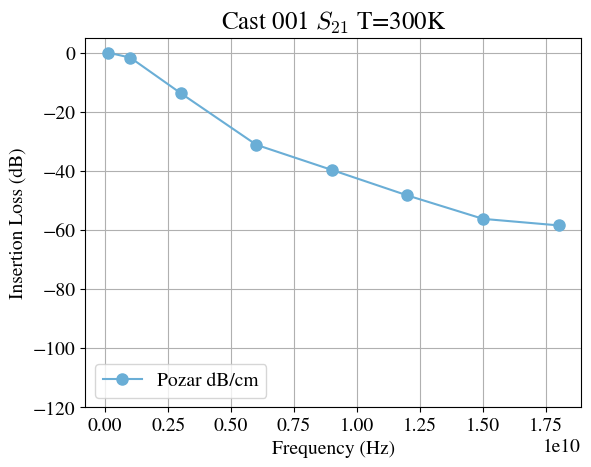

In [8]:
fig, (ax2) = plt.subplots(1)
# log scale
#ax2.plot(x_vals*1e9, y_median_curve, label='Median Filter', color=plt.cm.Blues(0.8))#, color=plt.cm.plasma(0.1))
#ax2.fill_between(x_vals*1e9, y_min_curve, y_max_curve, alpha=0.2, label='Variation (19 Filters)', color=plt.cm.Blues(0.8))#, color=plt.cm.plasma(0.1))
ax2.plot(freq, -attenuation_dB_cm, marker='o', markersize=8, linestyle='-', label='Pozar dB/cm', color=plt.cm.Blues(0.5))#, color=plt.cm.plasma(0.4))
#ax2.plot(target_freq, -dBcm, marker='o', linestyle='-', label='Laird dB/cm', color='orange')#, color=plt.cm.plasma(0.75))
#ax2.plot(target_freq, -dB_per_cm, marker='o', linestyle='-', label='Data Sheet dB/cm', color=plt.cm.Set2(.7))#, color=plt.cm.plasma(0.95))
ax2.ticklabel_format(useOffset=False)
ax2.legend(loc='lower left')
ax2.set_title("Cast 001 $S_{21}$ T=300K")
ax2.set_xlabel("Frequency (Hz)")
#ax2.set_xscale('log')
ax2.set_ylabel("Insertion Loss (dB)")
ax2.set_ylim(-120, 5)
ax2.grid(which='both');

#plt.savefig("001CS2177K.png", dpi=300, bbox_inches='tight', facecolor='w')



<p style="text-align: center;">
  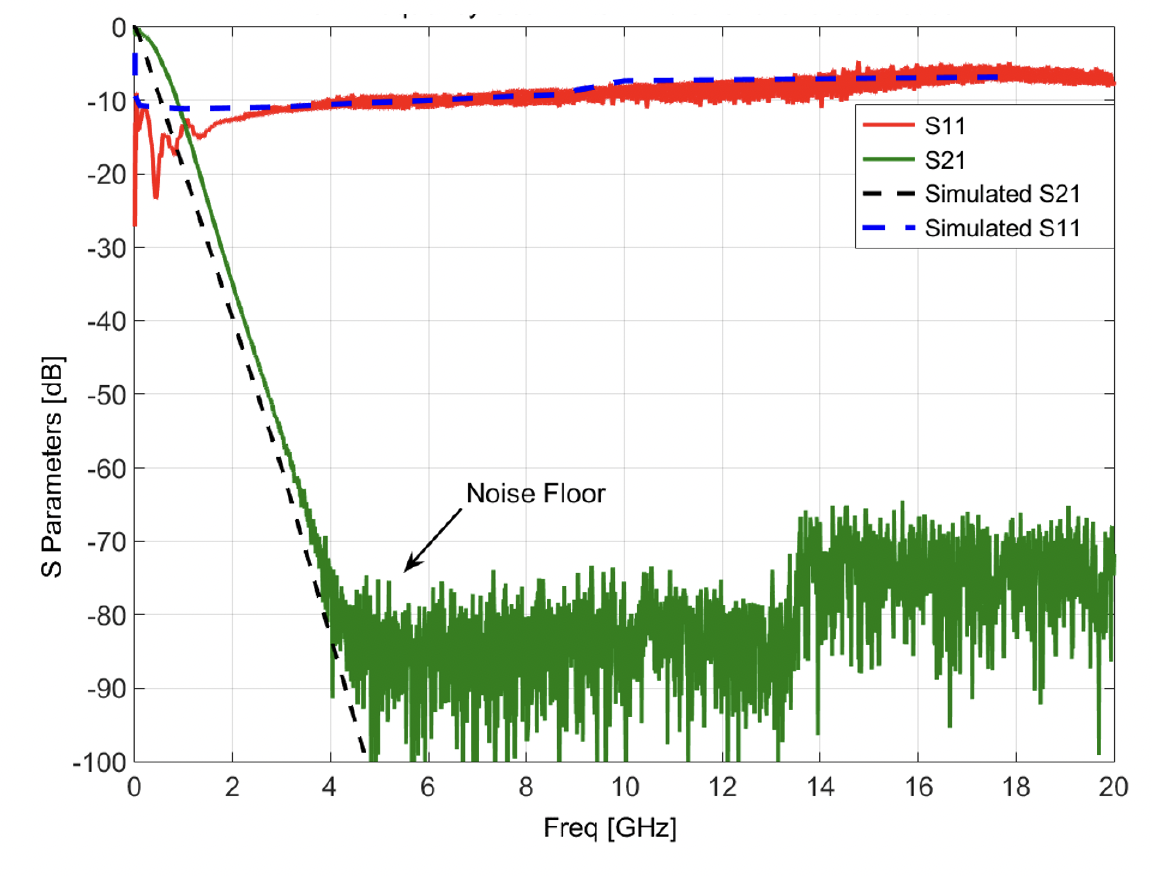
  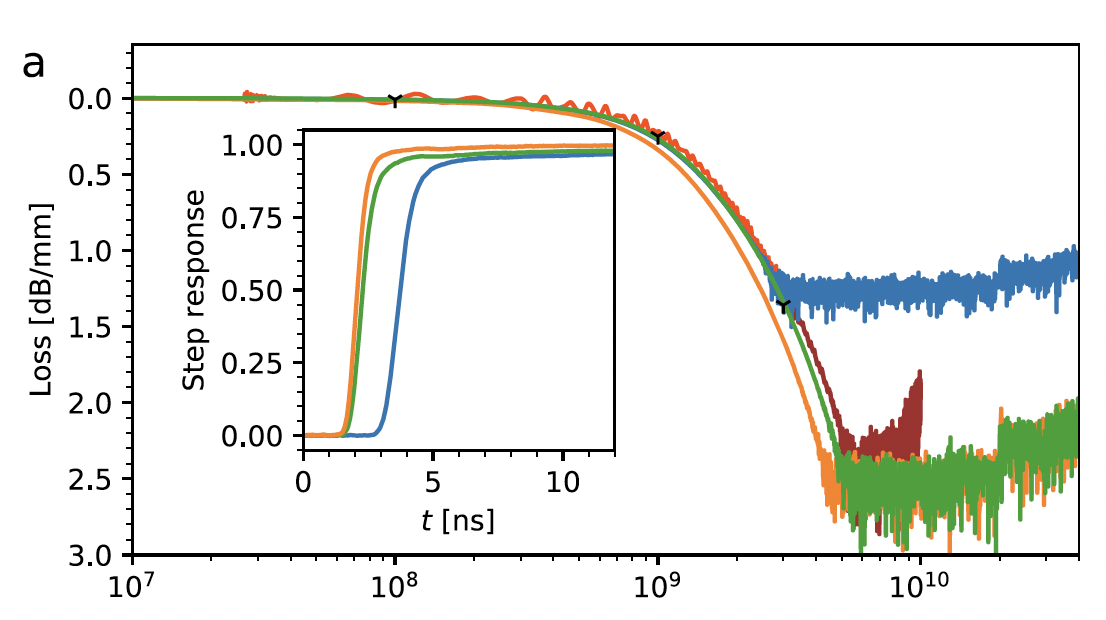
</p>


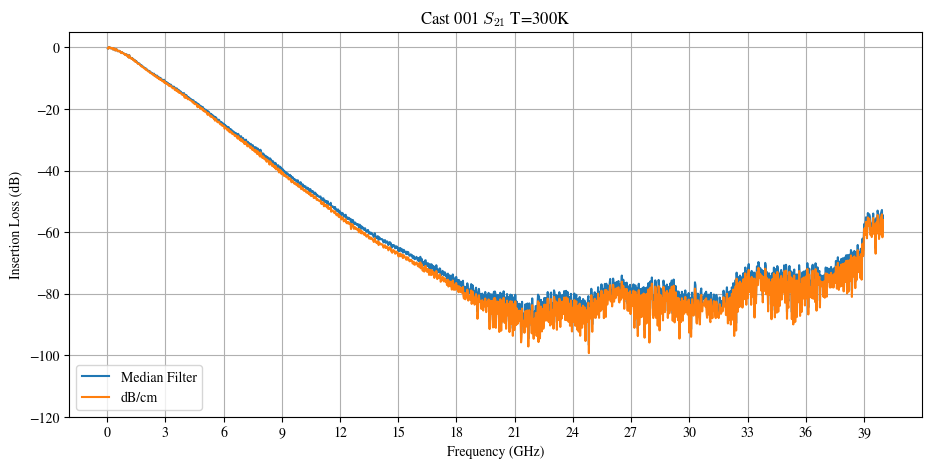

In [27]:
fig, (ax1) = plt.subplots(1, figsize=(11, 5))
# Linear scale
ax1.plot(x_vals, y_median_curve, label='Median Filter')#, color=plt.cm.plasma(0.1))
ax1.plot(x_vals, y_median_curve / (z * 100), label='dB/cm')#, color=plt.cm.plasma(0.1))
ax1.ticklabel_format(useOffset=True)
ax1.legend(loc='lower left')
ax1.set_title("Cast 001 $S_{21}$ T=300K")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Insertion Loss (dB)")
ax1.set_ylim(-120, 5)
ax1.set_xticks(xticks_full)
ax1.grid(which='both');